#### Setup Imports

In [382]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix


#### Setup Variables

Setting up the path for datasets.
Features list is used to select features we want to train our model on.
Add or remove by deleting from the list.

In [383]:
mutations_file_path = "/Users/yagizbatu/Documents/projects/mutationPredict/prepareToClassify.csv"
predict_file_path = "/Users/yagizbatu/Documents/projects/mutationPredict/allresults.txt"

toPredict = pd.read_csv(predict_file_path, sep="\t")
mutations = pd.read_csv(mutations_file_path)

features = ['Template_sequence_identity', 'Alignment_score',
       'Interactor_template_sequence_identity', 'Interactor_alignment_score',
       'Model/DOPE_score', 'Matrix_score', 'Solvent_accessibility_wt',
       'Solvent_accessibility_mut', 'pcv_salt_equal_wt',
       'pcv_salt_opposite_wt', 'pcv_hbond_wt', 'pcv_vdW_wt',
       'pcv_salt_equal_mut', 'pcv_salt_opposite_mut', 'pcv_hbond_mut',
       'pcv_vdW_mut', 'pcv_salt_equal_self_wt', 'pcv_salt_opposite_self_wt',
       'pcv_hbond_self_wt', 'pcv_vdW_self_wt', 'pcv_salt_equal_self_mut',
       'pcv_salt_opposite_self_mut', 'pcv_hbond_self_mut', 'pcv_vdW_self_mut',
       'dg_wt', 'backbone_hbond_wt', 'sidechain_hbond_wt', 'van_der_waals_wt',
       'electrostatics_wt', 'solvation_polar_wt', 'solvation_hydrophobic_wt',
       'van_der_waals_clashes_wt', 'entropy_sidechain_wt',
       'entropy_mainchain_wt', 'sloop_entropy_wt', 'mloop_entropy_wt',
       'cis_bond_wt', 'torsional_clash_wt', 'backbone_clash_wt',
       'helix_dipole_wt', 'water_bridge_wt', 'disulfide_wt',
       'electrostatic_kon_wt', 'partial_covalent_bonds_wt',
       'energy_ionisation_wt', 'entropy_complex_wt', 'number_of_residues_wt',
       'dg_mut', 'backbone_hbond_mut', 'sidechain_hbond_mut',
       'van_der_waals_mut', 'electrostatics_mut', 'solvation_polar_mut',
       'solvation_hydrophobic_mut', 'van_der_waals_clashes_mut',
       'entropy_sidechain_mut', 'entropy_mainchain_mut', 'sloop_entropy_mut',
       'mloop_entropy_mut', 'cis_bond_mut', 'torsional_clash_mut',
       'backbone_clash_mut', 'helix_dipole_mut', 'water_bridge_mut',
       'disulfide_mut', 'electrostatic_kon_mut', 'partial_covalent_bonds_mut',
       'energy_ionisation_mut', 'entropy_complex_mut',
       'number_of_residues_mut', 'IntraclashesEnergy1_wt',
       'IntraclashesEnergy1_mut', 'IntraclashesEnergy2_wt',
       'IntraclashesEnergy2_mut', 'Interface_contact_distance_wt',
       'Interface_contact_distance_mut', 'Final_ddG']
target = 'feature_type'

#### Data preprocessing

From the data the labels are chosen which the model is going to be trained on.

In [384]:
toDrop = ['mutation decreasing rate(MI:1130)', 'mutation increasing rate(MI:1131)',
         'mutation increasing strength(MI:1132)', 'mutation decreasing strength(MI:1133)','mutation decreasing(MI:0119)', 
         'mutation increasing(MI:0382)']

mutations_dropped = mutations[mutations.feature_type != 'mutation decreasing rate(MI:1130)']
#mutations_dropped = mutations_dropped[mutations_dropped.feature_type != 'mutation increasing rate(MI:1131)']
#mutations_dropped = mutations_dropped[mutations_dropped.feature_type != 'mutation increasing strength(MI:1132)']
mutations_dropped = mutations_dropped[mutations_dropped.feature_type != 'mutation decreasing strength(MI:1133)']
mutations_dropped = mutations_dropped[mutations_dropped.feature_type != 'mutation decreasing(MI:0119)']
#mutations_dropped = mutations_dropped[mutations_dropped.feature_type != 'mutation increasing(MI:0382)']
mutations_dropped = mutations_dropped[mutations_dropped.feature_type != 'mutation causing(MI:2227)']
mutations_dropped = mutations_dropped[mutations_dropped.feature_type != 'mutation(MI:0118)']
print(mutations.shape)
print(mutations_dropped.shape)


(4692, 102)
(3525, 102)


#### Feature Binning 

For this model 2 classes are used so the data is binned, disrupting to one, increasing and no effect to other.

In [385]:
replace_map = {'feature_type': {'mutation disrupting(MI:0573)': 1,
                                'mutation disrupting strength(MI:1128)': 1,
                                'mutation with no effect(MI:2226)': 2, 'mutation disrupting rate(MI:1129)': 1,
                               'mutation increasing(MI:0382)': 2, 'mutation increasing strength(MI:1132)': 2,
                               'mutation increasing rate(MI:1131)': 2}}
mutations_cat = mutations_dropped.copy()
mutations_cat.replace(replace_map, inplace=True)
mutations_cat['feature_type'].head

<bound method NDFrame.head of 15      1
16      1
17      1
18      1
19      1
       ..
4658    2
4661    2
4666    2
4667    2
4668    2
Name: feature_type, Length: 3525, dtype: int64>

#### Setup training and test variables

At this point the data is preprocessed and the train and test variables are initialized. 

In [386]:
X = mutations_cat[features]
y = mutations_cat.feature_type


predict_X = toPredict[features]


train_X_full, val_X_full, train_y, val_y = train_test_split(X, y, random_state=0)

#### Data Exploration

In [387]:
print(y.value_counts())

print(X.head)

1    2171
2    1354
Name: feature_type, dtype: int64
<bound method NDFrame.head of      Template_sequence_identity Alignment_score  \
15                          1.0             1.0   
16                          1.0             1.0   
17                          1.0        0.946667   
18                       0.9577        0.908625   
19                       0.9577        0.908625   
...                         ...             ...   
4658                     0.9897        0.728649   
4661                     0.2762        0.224393   
4666                     0.7922        0.393627   
4667                     0.3333        0.168138   
4668                     0.3333        0.168138   

     Interactor_template_sequence_identity Interactor_alignment_score  \
15                                  0.4552                   0.454245   
16                                  0.8707                   0.877165   
17                                     1.0                   0.972414   
18          

### Data cleaning

Simple processes to clean up the data,
To fill in the empty data Imputer is used, for numerical strategy is constant which fills with 0.
For categorical data strategy is most frequent.
Categorical data also is encoded with one hot encoder.

In [388]:
numerical_cols = [cname for cname in train_X_full.columns if train_X_full[cname].dtype in ['int64', 'float64']]

categorical_cols = categorical_cols = [cname for cname in train_X_full.columns if train_X_full[cname].dtype == "object"]



my_cols = numerical_cols + categorical_cols
train_X = train_X_full[my_cols].copy()
val_X = val_X_full[my_cols].copy()
print(val_X.shape)
print(train_X.shape)

(882, 77)
(2643, 77)


#### Fitting and Tuning

Fitting and tuning the model for better results.
Looking at confusion matrix we can see results are really unbalanced. This is the main issue with the dataset and there is not much solution but binning some feature types together.

In [389]:

#clearing numerical data
numerical_transformer = SimpleImputer(strategy='constant')
#categorical
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model = XGBClassifier( learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', model)
                             ])

my_pipeline.fit(train_X, train_y)
FirstScore = my_pipeline.score(val_X, val_y)

In [390]:
preds = my_pipeline.predict(val_X)
print(FirstScore)
print(confusion_matrix(val_y, preds))

0.8276643990929705
[[473  76]
 [ 76 257]]


#### Model Selection

The data is labeled so couple of supervised learning algorithms are tested.
I picked XGBoost as all of the algoriths performed similar but XGBoost has more room for optimizing and also the most popular.

Performance for this dataset : mean of 70 percent and deviation around 20.
This performance makes sense considering the binning we have to perform so the dataset is not unbalanced.

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Rf: 0.706805 (0.213275)


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


XGB: 0.706805 (0.213275)


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Ada: 0.707373 (0.213466)


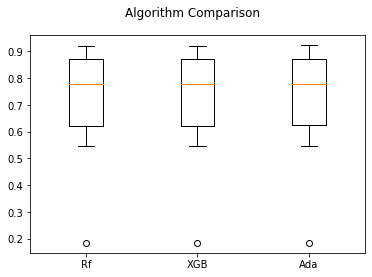

In [312]:
seed = 7
models = []
models.append(('Rf', RandomForestClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('Ada', AdaBoostClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(my_pipeline, X, y, cv=kfold)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Final training and output

Since the final model is chosen the split is not needed anymore. Thats the reason X and y is used here.

The prediction is done and printed to a file in the path with accuracy.

In [391]:
# Print the feature ranking
#print("Feature ranking:")
#for f in range(X.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
#my_pipeline.score(val_X, val_y)
my_pipeline.fit(X, y)
realpreds = my_pipeline.predict(predict_X)
#acc = accuracy_score(val_y, preds)
#print(' balanced acc:', score)
#print(' acc:', acc)
f = open("noeff+incvsdisruptiveV2.txt", "w")
f.write("accuracy: " + str(FirstScore))
f.write("\t1 = disruptive, 2 = no effect or increasing\n")
for i in range(1,len(realpreds)):
    f.write(str(realpreds[i]))
    f.write("\t" + toPredict["Input_identifier"][i] + "." + toPredict["Mutation"][i] + "\n")